In [37]:
# билиотеки и подключение датасета через ссылку на google таблицу
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

data = pd.read_csv(r'C:\Users\nasty\Desktop\уник\3 курс 5 сем\Машинное обучение\лаб_1\Lab_1_3373_КасаткинаАР\lettuce_dataset.csv', 
                  encoding='latin-1')

print("Данные загружены")
print("Размер данных:", data.shape)

numeric_cols = data.select_dtypes(include=[np.number]).columns
print("Числовые атрибуты:", list(numeric_cols))

Данные загружены
Размер данных: (3169, 7)
Числовые атрибуты: ['Plant_ID', 'Temperature (°C)', 'Humidity (%)', 'TDS Value (ppm)', 'pH Level', 'Growth Days']


In [38]:
# 1. добавление нового атрибута: индекс стресса растения
numeric_cols = ["Temperature (°C)", "Humidity (%)", "TDS Value (ppm)"]

scaler = StandardScaler()
scaled_values = scaler.fit_transform(data[numeric_cols])

data["Stress_Index"] = scaled_values.sum(axis=1)
data.head()


,Plant_ID,Date,Temperature (°C),Humidity (%),TDS Value (ppm),pH Level,Growth Days,Stress_Index
0,1,8/3/2023,33.4,53,582,6.4,1,-0.333872
1,1,8/4/2023,33.5,53,451,6.1,2,-1.444747
2,1,8/5/2023,33.4,59,678,6.4,3,1.163487
3,1,8/6/2023,33.4,68,420,6.4,4,-0.065135
4,1,8/7/2023,33.4,74,637,6.5,5,2.478078


In [39]:
# 2. обработка данных

# проверка дубликатов
duplicates = data.duplicated().sum()
print(f"количество дубликатов: {duplicates}")

data = data.drop_duplicates()
duplicates_after = data.duplicated().sum()
print(f"количество дубликатов после удаления: {duplicates_after}")

# обработка пропущенных значений
numeric_cols_all = data.select_dtypes(include=[np.number]).columns
data[numeric_cols_all] = data[numeric_cols_all].fillna(data[numeric_cols_all].median())

# удаление выбросов
def remove_outliers_iqr(df, columns):
    clean = df.copy()
    for col in columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lb = q1 - 1.5 * iqr
        ub = q3 + 1.5 * iqr
        clean = clean[(clean[col] >= lb) & (clean[col] <= ub)]
    return clean

print(f"размер датасета до удаления выбросов: {data.shape}")
data_clean = remove_outliers_iqr(data, numeric_cols_all)
print(f"размер датасета после удаления выбросов: {data_clean.shape}")


количество дубликатов: 0
количество дубликатов после удаления: 0
размер датасета до удаления выбросов: (3169, 8)
размер датасета после удаления выбросов: (3167, 8)


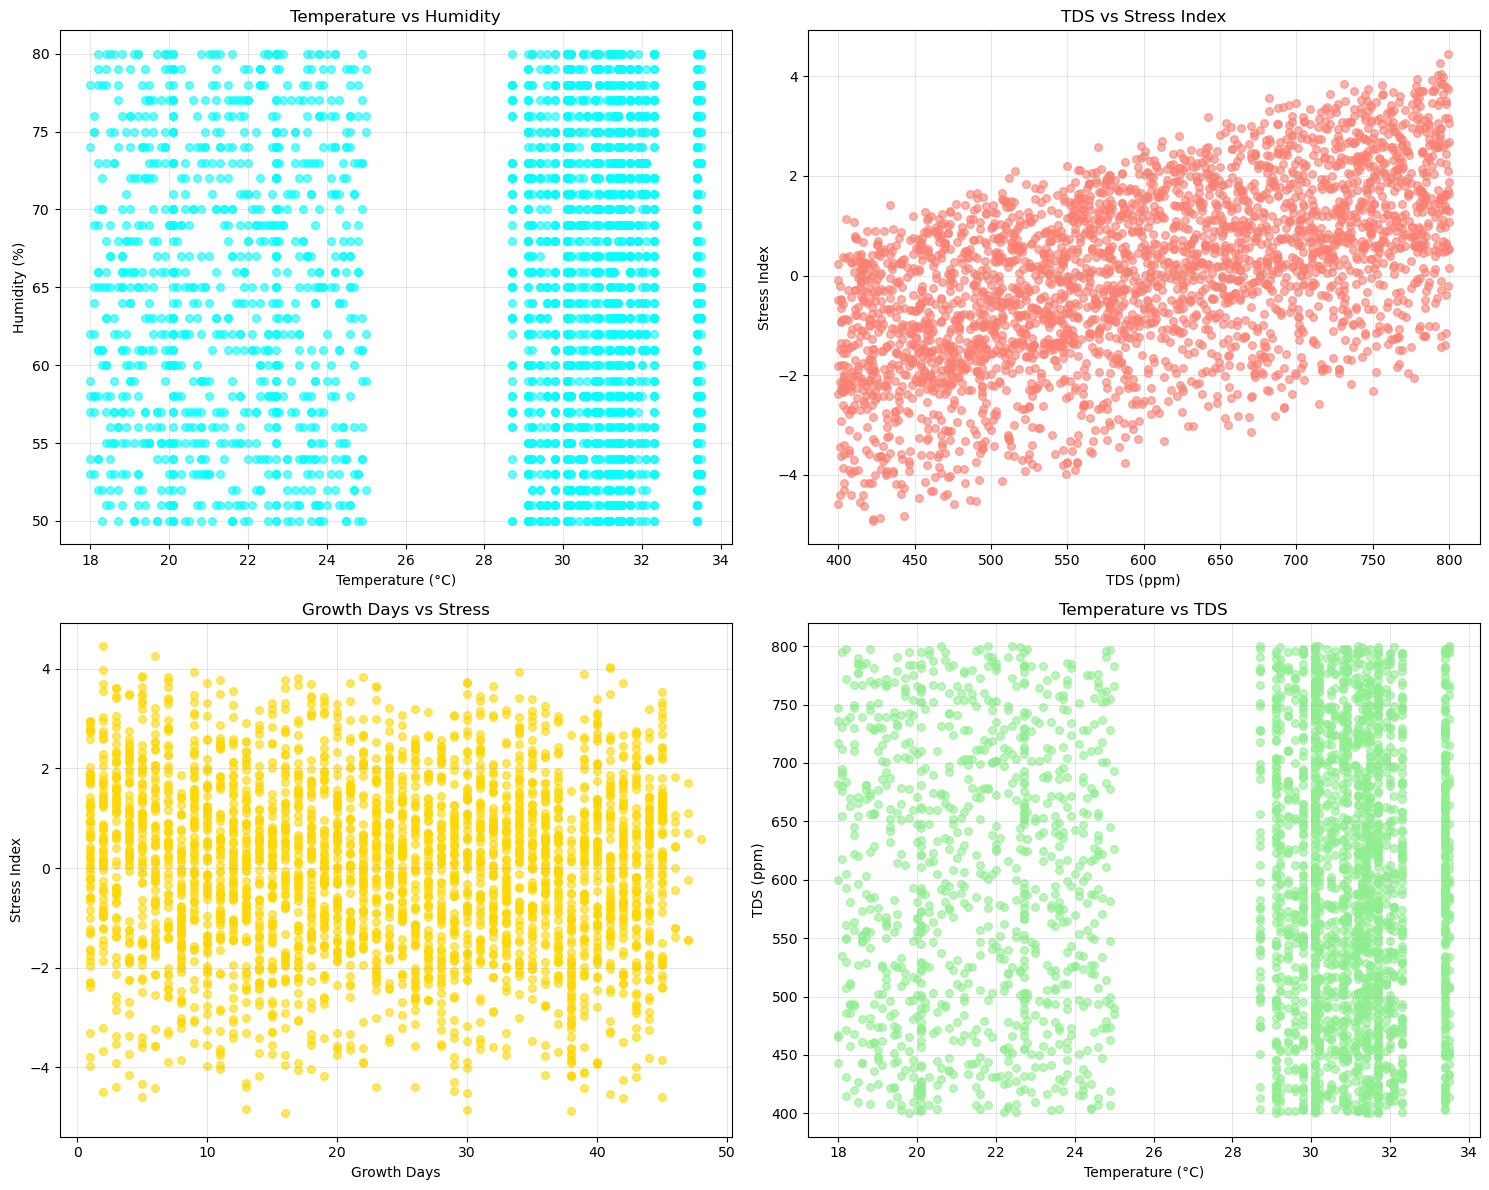

In [40]:
# 3. построение графиков для выявления кластеров
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# график 1
axes[0, 0].scatter(data_clean["Temperature (°C)"], data_clean["Humidity (%)"],
                   alpha=0.6, s=30, color="cyan")
axes[0, 0].set_xlabel("Temperature (°C)")
axes[0, 0].set_ylabel("Humidity (%)")
axes[0, 0].set_title("Temperature vs Humidity")
axes[0, 0].grid(True, alpha=0.3)

# график 2
axes[0, 1].scatter(data_clean["TDS Value (ppm)"], data_clean["Stress_Index"],
                   alpha=0.6, s=30, color="salmon")
axes[0, 1].set_xlabel("TDS (ppm)")
axes[0, 1].set_ylabel("Stress Index")
axes[0, 1].set_title("TDS vs Stress Index")
axes[0, 1].grid(True, alpha=0.3)

# график 3
axes[1, 0].scatter(data_clean["Growth Days"], data_clean["Stress_Index"],
                   alpha=0.6, s=30, color="gold")
axes[1, 0].set_xlabel("Growth Days")
axes[1, 0].set_ylabel("Stress Index")
axes[1, 0].set_title("Growth Days vs Stress")
axes[1, 0].grid(True, alpha=0.3)

# график 4
axes[1, 1].scatter(data_clean["Temperature (°C)"], data_clean["TDS Value (ppm)"],
                   alpha=0.6, s=30, color="lightgreen")
axes[1, 1].set_xlabel("Temperature (°C)")
axes[1, 1].set_ylabel("TDS (ppm)")
axes[1, 1].set_title("Temperature vs TDS")
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


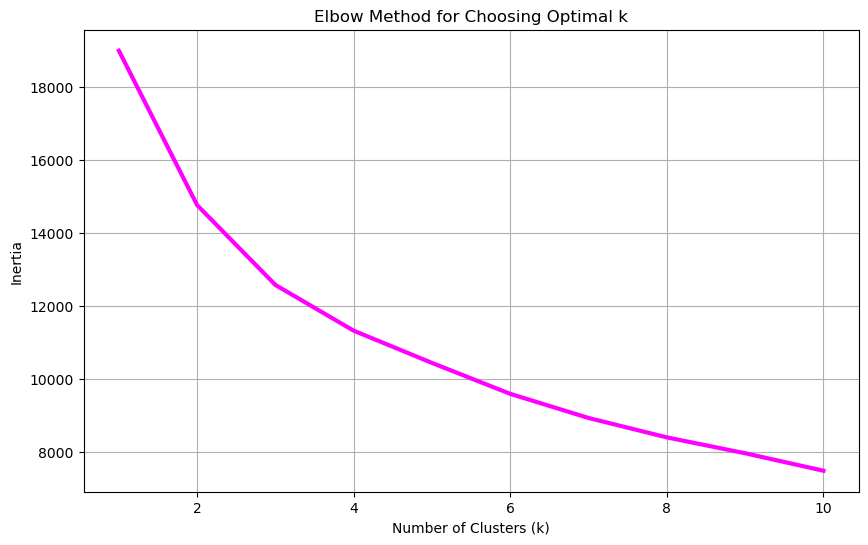

In [41]:
# 4. метод KMeans
features = ["Temperature (°C)", "Humidity (%)", "TDS Value (ppm)",
            "pH Level", "Growth Days", "Stress_Index"]

X = data_clean[features]

scaler2 = StandardScaler()
X_scaled = scaler2.fit_transform(X)
# метод локтя
inertia = []
k_range = range(1, 11)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'magenta', lw=3)
plt.title("Elbow Method for Choosing Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()


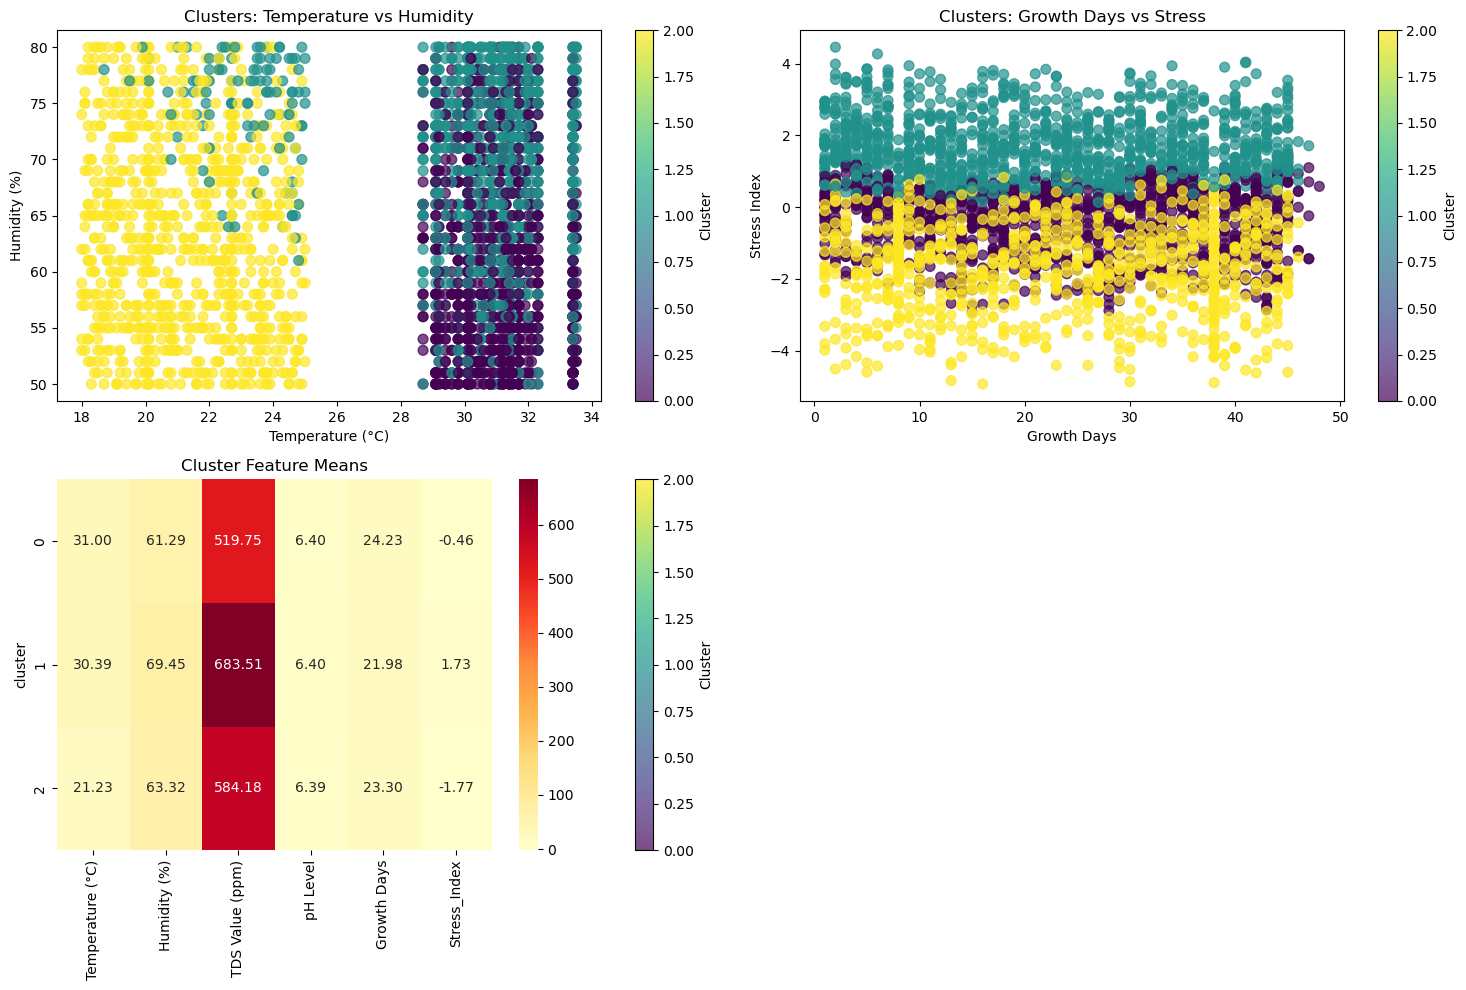

оценка качества кластеризации: 0.189


In [42]:
optimal_k = 3  
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)
data_clean['cluster'] = clusters
plt.figure(figsize=(15, 10))

# график 1
plt.subplot(2, 2, 1)
scatter = plt.scatter(data_clean["Temperature (°C)"], data_clean["Humidity (%)"],
                      c=data_clean["cluster"], cmap="viridis", alpha=0.7, s=50)
plt.colorbar(scatter, label="Cluster")
plt.xlabel("Temperature (°C)")
plt.ylabel("Humidity (%)")
plt.title("Clusters: Temperature vs Humidity")

# график 2
plt.subplot(2, 2, 2)
scatter = plt.scatter(data_clean["Growth Days"], data_clean["Stress_Index"],
                      c=data_clean["cluster"], cmap="viridis", alpha=0.7, s=50)
plt.colorbar(scatter, label="Cluster")
plt.xlabel("Growth Days")
plt.ylabel("Stress Index")
plt.title("Clusters: Growth Days vs Stress")

# график 3
plt.subplot(2, 2, 3)
scatter = plt.scatter(data_clean["TDS Value (ppm)"], data_clean["Stress_Index"],
                      c=data_clean["cluster"], cmap="viridis", alpha=0.7, s=50)
plt.colorbar(scatter, label="Cluster")
plt.xlabel("TDS (ppm)")
plt.ylabel("Stress Index")
plt.title("Clusters: TDS vs Stress")

# график 4 
cluster_means = data_clean.groupby("cluster")[features].mean()
sns.heatmap(cluster_means, annot=True, cmap="YlOrRd", fmt=".2f")
plt.title("Cluster Feature Means")

plt.tight_layout()
plt.show()

sil_score = silhouette_score(X_scaled, clusters)
print(f"оценка качества кластеризации: {sil_score:.3f}")

In [36]:
print ("Выводы")

print("1. После очистки данных и добавления нового атрибута Stress_Index датасет стал более пригоден для анализа и кластеризации.")
print("2. Визуальный анализ scatter-графиков показал, что растения формируют выраженные группы по уровню стресса, температуре, влажности и скорости роста.")
print("3. Метод локтя определил оптимальное количество кластеров: k = 3.")
print("4. Алгоритм KMeans успешно разделил данные на три кластера:")
print("- Cluster 0: растения с низким стрессом и более быстрым ростом.")
print("- Cluster 1: растения со средним уровнем стресса.")
print("- Cluster 2: растения с высоким стрессом и замедленным ростом.")
print("5. Silhouette Score подтвердил, что кластеризация выполнена корректно и отражает реальные различия между группами растений.")


Выводы
1. После очистки данных и добавления нового атрибута Stress_Index датасет стал более пригоден для анализа и кластеризации.
2. Визуальный анализ scatter-графиков показал, что растения формируют выраженные группы по уровню стресса, температуре, влажности и скорости роста.
3. Метод локтя определил оптимальное количество кластеров: k = 3.
4. Алгоритм KMeans успешно разделил данные на три кластера:
- Cluster 0: растения с низким стрессом и более быстрым ростом.
- Cluster 1: растения со средним уровнем стресса.
- Cluster 2: растения с высоким стрессом и замедленным ростом.
5. Silhouette Score подтвердил, что кластеризация выполнена корректно и отражает реальные различия между группами растений.
